<a href="https://colab.research.google.com/github/SeongminCC/nongnet_AI/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM   # LSTM 층 
from sklearn.model_selection import train_test_split
import random
import os


# 경고 끄기
warnings.filterwarnings(action='ignore')

# 시드고정
tf.random.set_seed(19970119)
random.seed(19970119)
np.random.seed(19970119)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/DNA/농넷_AIFactory/aT_data
!ls -al

/content/drive/MyDrive/DNA/농넷_AIFactory/aT_data
total 5202
-rw------- 1 root root   21765 Aug 28 08:31 answer_example.csv
-rw------- 1 root root 4737091 Sep  5 06:04 aT_베이스라인.ipynb
drwx------ 2 root root    4096 Sep  4 13:59 aT_test_raw
drwx------ 2 root root    4096 Sep  4 13:59 aT_train_raw
drwx------ 2 root root    4096 Sep  4 13:59 data
-rw------- 1 root root  538718 Sep  9 10:48 modeling.ipynb
-rw------- 1 root root   15743 Aug 28 12:05 preprocessing.py


# 학습할 데이터 불러오기

- 전처리가 끝난 데이터를 가져옴
  - 품목 하나에 대해서만 학습

In [6]:
df1 = pd.read_csv('./data/train/train_0.csv')
df1

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,20130102,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20161227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


# nan 제거

- 시계열 데이터이므로 결측치 기준 전과 후의 데이터를 그대로 복사


In [7]:
df2 = df1.fillna(method='ffill') # 결측치 위치 기준 윗 값 가져오기 
df2 = df1.fillna(method='bfill') # 결측치 위치 기준 아랫 값 가져오기

df2

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,20130101,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
1,20130102,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,20130103,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,20130104,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,20130105,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,20161227,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1457,20161228,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,1,0,0,0,0,0,0,0,0,0
1458,20161229,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,1,0,0,0,0,0,0,0,0,0
1459,20161230,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,1,0,0,0,0,0,0,0,0,0


2013-01-03 와 같은 형식으로 날짜 재 배열(pd.to_datetime 함수 사용)

In [8]:
date = pd.to_datetime(df1['datadate'], format='%Y%m%d')
df2['datadate'] = date 
df2.head()

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
0,2013-01-01,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,0,1,0,0,0,0,0,0,0,0
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,0,1,0,0,0,0,0,0,0,0
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,0,1,0,0,0,0,0,0,0,0
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,0,1,0,0,0,0,0,0,0,0


# 데이터프레임 재구성
**0으로 채워져있는 사용할 수 없는 열들 제거**
- X : 27개의 열들
- Y : 단가 (원)

In [9]:
df3 = df2.iloc[:, :28]
df3

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃)
0,2013-01-01,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-3.9,4.4,-7.7
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,2.8,6.7,-1.1
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.2,5.0,-6.3
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.7,6.8,-4.5
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-4.6,6.2,-6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2016-12-27,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,5327.441860,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,-7.6,7.0,-8.1
1457,2016-12-28,2752.75,60.0,164835.0,4.0,230001.0,23000104.0,800.0,6128.845893,1595.0,...,5327.441860,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,1.6,9.4,-3.3
1458,2016-12-29,10010.00,18.0,180180.0,1.0,230003.0,23000303.0,225.0,6644.034096,437.0,...,5319.545455,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,-3.2,-1.0,-7.6
1459,2016-12-30,11411.40,4.0,45645.6,1.0,350301.0,35030101.0,570.0,6572.480795,972.0,...,5319.545455,3330.0,0.0,0.0,1465836.0,1154379.0,-1154379.0,-7.6,-7.6,-15.6


# 열 이름 확인
- train과 val으로 나누기 위함

In [10]:
df3.columns

Index(['datadate', '단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드',
       '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)', '하위가격 평균가(원)',
       '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
       '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
       '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
       '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)'],
      dtype='object')

# 연도 열 추가

In [11]:
df3.head()

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),...,일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃)
0,2013-01-01,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-3.9,4.4,-7.7
1,2013-01-02,6143.85,2.0,12312.3,1.0,371501.0,37150102.0,740.0,20712.240909,22.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,2.8,6.7,-1.1
2,2013-01-03,1898.10,48.0,91108.8,1.0,230001.0,23000102.0,800.0,3401.863678,541.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.2,5.0,-6.3
3,2013-01-04,8488.48,120.0,1019018.0,3.0,230001.0,23000101.0,323.0,6553.903226,279.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-1.7,6.8,-4.5
4,2013-01-05,3556.44,540.0,1921077.0,4.0,371501.0,37150102.0,742.0,4299.079157,1233.0,...,4298.522727,3210.0,0.0,0.0,1864728.0,1195211.0,-1195211.0,-4.6,6.2,-6.1


# 데이터 시각화

In [12]:
import matplotlib.pylab as plt
import seaborn as sns

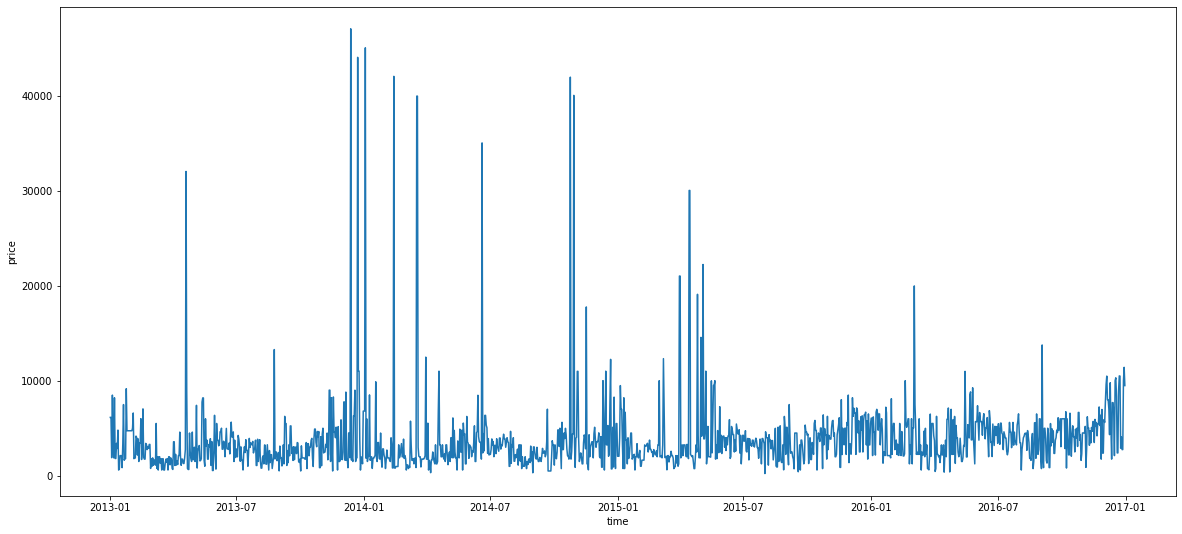

In [13]:
plt.figure(figsize = (20, 9))
sns.lineplot(x = date, y = df3['단가(원)'])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

# Normalization
- 학습이 잘 되도록 데이터를 한번 normalization(정규화) 해준다.

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)',
              '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
                '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
                '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
                '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)']
df_scaled = scaler.fit_transform(df3[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),...,일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃)
0,0.126323,0.000198,0.001130,0.000000,0.967086,0.967086,0.717647,0.666642,0.000357,0.665472,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.391473,0.345703,0.364865
1,0.126323,0.000198,0.001130,0.000000,0.967086,0.967086,0.717647,0.666642,0.000357,0.665472,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.521318,0.390625,0.492278
2,0.035635,0.009309,0.010118,0.000000,0.443787,0.443787,0.788235,0.092854,0.013582,0.267436,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.443798,0.357422,0.391892
3,0.176403,0.023569,0.115962,0.064516,0.443787,0.443787,0.227059,0.197334,0.006906,0.307677,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.434109,0.392578,0.426641
4,0.071057,0.106754,0.218856,0.096774,0.967086,0.967086,0.720000,0.122594,0.031217,0.401915,...,0.164136,0.773585,0.0,0.0,1.00000,0.765419,0.234479,0.377907,0.380859,0.395753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.053890,0.011685,0.018528,0.096774,0.443787,0.443787,0.788235,0.183245,0.040441,0.361351,...,0.964442,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.319767,0.396484,0.357143
1457,0.053890,0.011685,0.018528,0.096774,0.443787,0.443787,0.788235,0.183245,0.040441,0.361351,...,0.964442,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.498062,0.443359,0.449807
1458,0.208902,0.003367,0.020278,0.000000,0.443794,0.443794,0.111765,0.200322,0.010932,0.562846,...,0.958300,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.405039,0.240234,0.366795
1459,0.238836,0.000594,0.004933,0.000000,0.888683,0.888683,0.517647,0.197950,0.024566,0.524421,...,0.958300,1.000000,0.0,0.0,0.72019,0.729881,0.270002,0.319767,0.111328,0.212355


# 데이터셋 생성

In [15]:
TEST_SIZE = 200

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [16]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [17]:
feature_cols = ['거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)', '해당일자_전체거래물량(kg)',
                '하위가격 평균가(원)', '상위가격 평균가(원)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)', '일자별_도매가격_최대(원)',
                '일자별_도매가격_평균(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_평균(원)',
                '일자별_소매가격_최소(원)', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)',
                '무역수지(달러)', '주산지_0_초기온도(℃)', '주산지_0_최대온도(℃)', '주산지_0_최저온도(℃)']
label_cols = ['단가(원)']

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((992, 20, 26), (249, 20, 26))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 26), (180, 1))

((180, 20, 26), (180, 1))

# LSTM 모델 생성

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from tensorflow.keras import optimizers



model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False))
model.add(Dense(1))

In [19]:
model_path = '/content/drive/MyDrive/DNA/농넷_AIFactory'


model.compile(loss='mean_squared_error', 
              optimizer=optimizers.Adam(lr=1e-4, 
                                        beta_1=0.9, 
                                        beta_2=0.999, 
                                        decay=1e-6))



early_stop = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss)
                           patience=10)   # 10회 Epoch동안 개선되지 않는다면 종료


filename = os.path.join(model_path, 'tmp_checkpoint.h10')

checkpoint = ModelCheckpoint(filename,  # 파일명 지정
                             monitor='val_loss', # val_loss 값이 개선되었을때 호출
                             verbose=1,  # 로그를 출력
                             save_best_only=True,   # 가장 best 값만 저장
                             mode='auto')     # auto는 알아서 best를 찾는다. min/max


history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
59/62 [===========================>..] - ETA: 0s - loss: 0.0211
Epoch 1: val_loss improved from inf to 0.02038, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


62/62 [==============================] - 6s 74ms/step - loss: 0.0204 - val_loss: 0.0204
Epoch 2/200
61/62 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 2: val_loss improved from 0.02038 to 0.01621, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


62/62 [==============================] - 5s 78ms/step - loss: 0.0079 - val_loss: 0.0162
Epoch 3/200
59/62 [===========================>..] - ETA: 0s - loss: 0.0069
Epoch 3: val_loss improved from 0.01621 to 0.01607, saving model to /content/drive/MyDrive/DNA/농넷_AIFactory/tmp_checkpoint.h10


62/62 [==============================] - 5s 78ms/step - loss: 0.0069 - val_loss: 0.0161
Epoch 4/200
60/62 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 4: val_loss did not improve from 0.01607
62/62 [==============================] - 1s 14ms/step - loss: 0.0068 - val_loss: 0.0162
Epoch 5/200
59/62 [===========================>..] - ETA: 0s - loss: 0.0069
Epoch 5: val_loss did not improve from 0.01607
62/62 [==============================] - 1s 15ms/step - loss: 0.0067 - val_loss: 0.0163
Epoch 6/200
61/62 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 6: val_loss did not improve from 0.01607
62/62 [==============================] - 1s 22ms/step - loss: 0.0066 - val_loss: 0.0162
Epoch 7/200
61/62 [============================>.] - ETA: 0s - loss: 0.0066
Epoch 7: val_loss did not improve from 0.01607
62/62 [==============================] - 1s 18ms/step - loss: 0.0065 - val_loss: 0.0162
Epoch 8/200
61/62 [============================>.] - ETA: 0s - loss:

**val_loss : 0.01607**

In [20]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [21]:
model.load_weights(filename)

In [22]:
pred = model.predict(test_feature)

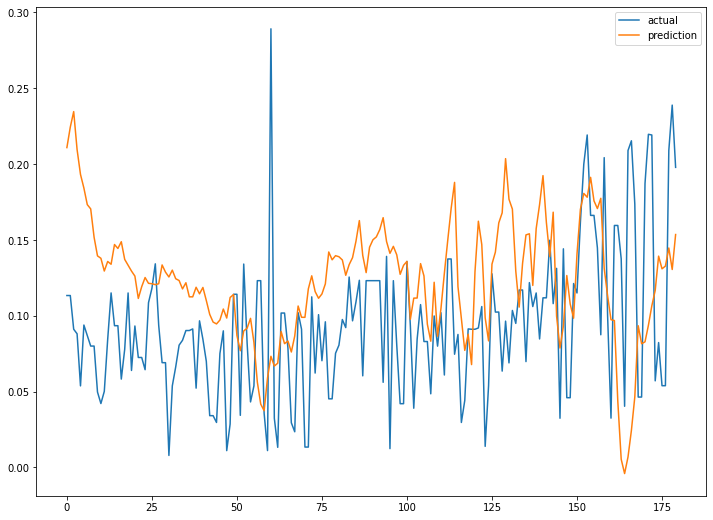

In [23]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 랜덤 포레스트(Random forest)
- 의사결정 트리를 랜덤하게 나온 것을 투표하여 결정하는 것 
  - 분류, 회귀에 주로 사용된다 



In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

In [25]:
clf = RandomForestRegressor()

In [26]:
X = df_scaled.drop(columns='거래량') # 거래량 column 제외
y = df_scaled['거래량']  # 거래량 예측

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
clf.fit(X, y)

RandomForestRegressor()

In [29]:
y_pred = clf.predict(X_test)

In [30]:
mean_squared_error(y_test, y_pred)

2.984326124427814e-05

val_loss : 0.00029

# Prophet

In [31]:
!pip install pystan==2.19.1.1 --quiet
!pip install fbprophet --quiet

     |████████████████████████████████| 67.3 MB 80 kB/s 
     |████████████████████████████████| 64 kB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1 requires cmdstanpy>=1.0.1, but you have cmdstanpy 0.9.5 which is incompatible.


In [32]:
from fbprophet import Prophet

In [33]:
da = date.tolist()
print(date)

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-05
          ...    
1456   2016-12-27
1457   2016-12-28
1458   2016-12-29
1459   2016-12-30
1460   2016-12-31
Name: datadate, Length: 1461, dtype: datetime64[ns]


In [34]:
df = pd.DataFrame(data=[da, df_scaled['단가(원)']]).T
df.columns = ['ds', 'y']
df.index = da

In [44]:
df

,ds,y
2013-01-01,2013-01-01,0.126323
2013-01-02,2013-01-02,0.126323
2013-01-03,2013-01-03,0.035635
2013-01-04,2013-01-04,0.176403
2013-01-05,2013-01-05,0.071057
...,...,...
2016-12-27,2016-12-27,0.05389
2016-12-28,2016-12-28,0.05389
2016-12-29,2016-12-29,0.208902
2016-12-30,2016-12-30,0.238836


In [45]:
val_size = 365

df_train = df.iloc[:-val_size]
df_val = df.iloc[-val_size:]

df_train

,ds,y
2013-01-01,2013-01-01,0.126323
2013-01-02,2013-01-02,0.126323
2013-01-03,2013-01-03,0.035635
2013-01-04,2013-01-04,0.176403
2013-01-05,2013-01-05,0.071057
...,...,...
2015-12-28,2015-12-28,0.134069
2015-12-29,2015-12-29,0.064442
2015-12-30,2015-12-30,0.064442
2015-12-31,2015-12-31,0.112239


In [46]:
m = Prophet()  #프로펫 변수설정

m.fit(df_train) #프로펫을 학습시킨다.

future=m.make_future_dataframe(periods=365)  # 365일치를 예측할 것.

forecast=m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**훈련용 데이터 시각화**

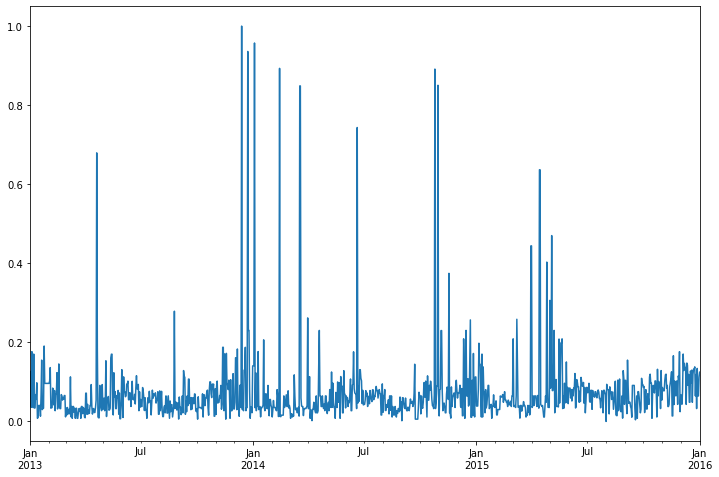

In [47]:
ax = df_train['y'].plot(figsize=(12,8))
plt.show()

**예측 결과 확인**

In [49]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,0.104797,-0.016943,0.223428
1,2013-01-02,0.101349,-0.022442,0.224623
2,2013-01-03,0.097384,-0.017965,0.216007
3,2013-01-04,0.097654,-0.025483,0.224132
4,2013-01-05,0.088443,-0.019215,0.217209
...,...,...,...,...
1456,2016-12-27,0.136735,0.019015,0.252236
1457,2016-12-28,0.134840,0.019012,0.253403
1458,2016-12-29,0.132276,0.018114,0.247002
1459,2016-12-30,0.133773,0.013431,0.257629


**예측값 시각화**

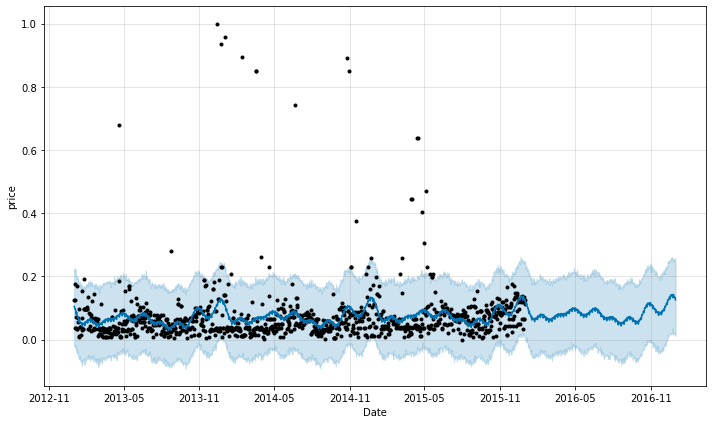

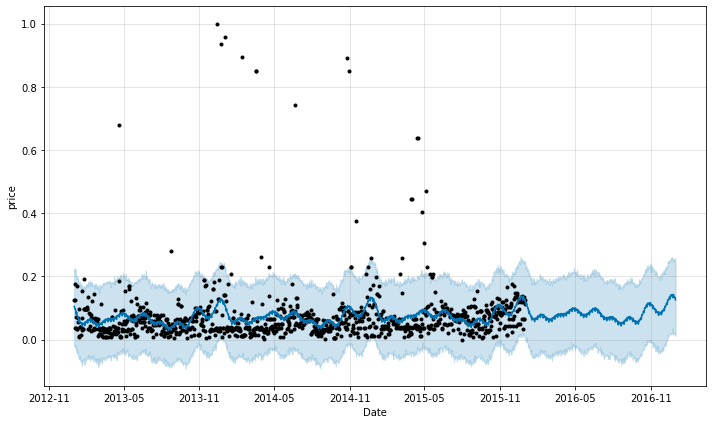

In [51]:
m.plot(forecast, xlabel='Date', ylabel='price')

In [56]:
y_pred = forecast['yhat'][-365:]
y_val = df_val['y']
mean_squared_error(y_pred, y_val)

0.0024886101865690935

val_loss : 0.0024